<a href="https://colab.research.google.com/github/sherlock-beep/tf_learn/blob/main/tf_learn4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用经典的 Auto MPG 数据集，构建了一个用来预测70年代末到80年代初汽车燃油效率的模型。
(使用tensorflow解决回归问题)

In [1]:
# 使用 seaborn 绘制矩阵图 (pairplot)
!pip install -q seaborn

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers



In [2]:
#获取数据集
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path


40960/30286 [========================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
#进行数据清洗
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
origin = dataset.pop('Origin')
origin

0      1
1      1
2      1
3      1
4      1
      ..
393    1
394    2
395    1
396    1
397    1
Name: Origin, Length: 392, dtype: int64

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [9]:
#对数据集分割为训练数据集和测试数据集（8-2）
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

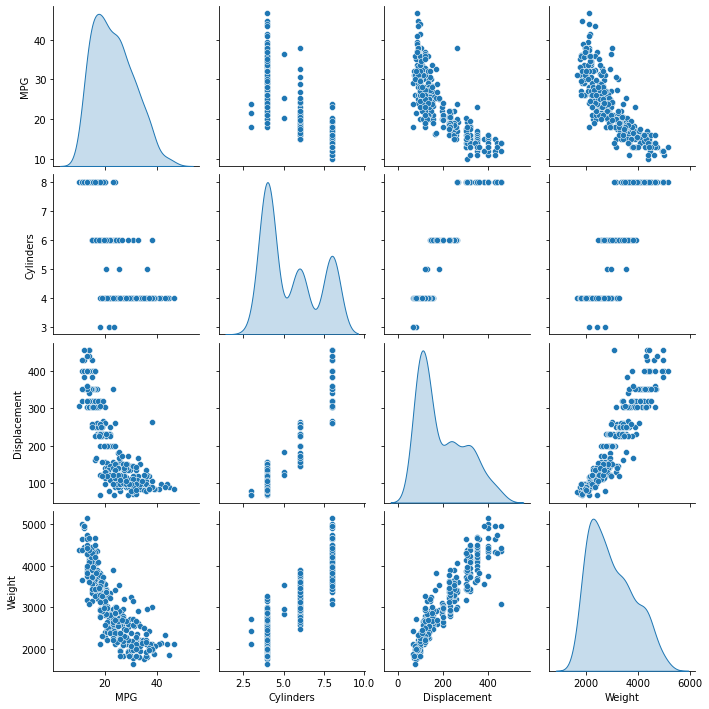

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [11]:
#查看总体的数据统计
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
#从数据集中分离目标值
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [13]:
train_dataset

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1.0,0.0,0.0
229,8,400.0,180.0,4220.0,11.1,77,1.0,0.0,0.0
150,4,108.0,93.0,2391.0,15.5,74,0.0,0.0,1.0
145,4,83.0,61.0,2003.0,19.0,74,0.0,0.0,1.0


In [14]:
#对特征进行归一化
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [15]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


9

In [16]:
#构建模型
def build_model():
  model = keras.Sequential([
    layers.Dense(64,activation='relu',input_shape=[len(train_dataset.keys())]),
    layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])
  #损失函数才用均方根误差
  #评分采用均方误差和平均绝对值误差
  model.compile(loss='mse',
                optimizer = tf.keras.optimizers.RMSprop(0.001),
                metrics=['mae','mse'])
  return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.59128034],
       [0.27234462],
       [0.4790138 ],
       [0.7455776 ],
       [0.6202345 ],
       [0.13796158],
       [0.61972594],
       [0.13057111],
       [0.11648114],
       [0.6709729 ]], dtype=float32)

In [18]:
#训练模型
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [39]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.618696,0.513845,0.618696,18.560280,3.120950,18.560280,995
996,0.594266,0.517494,0.594266,16.000795,2.903239,16.000795,996
997,0.673615,0.538379,0.673615,15.908846,2.860398,15.908846,997
998,0.574763,0.467113,0.574763,16.479761,2.975664,16.479761,998
999,0.663807,0.503719,0.663807,16.032549,2.921542,16.032549,999


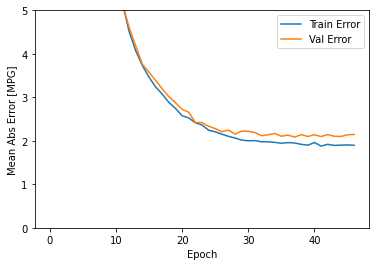

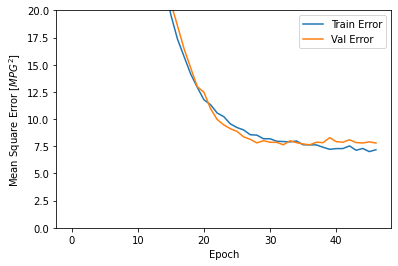

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


.....................................................................

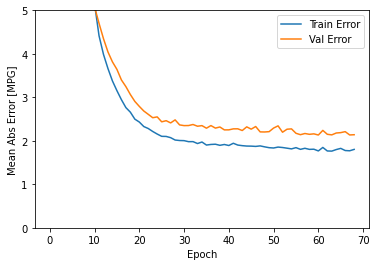

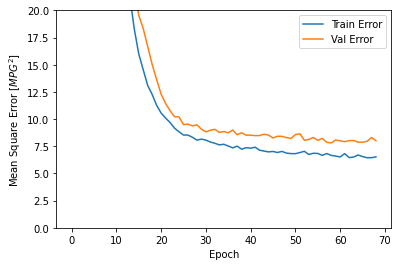

In [23]:
#设置回掉，在没有多个epochs之后误差没有改进提前停止训练
model = build_model()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(normed_train_data,train_labels,epochs=EPOCHS,
                    validation_split=0.2,verbose=0,callbacks=[early_stop,PrintDot()])
plot_history(history)

In [25]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7075 - mae: 1.9400 - mse: 5.7075 - 24ms/epoch - 8ms/step
Testing set Mean Abs Error:  1.94 MPG


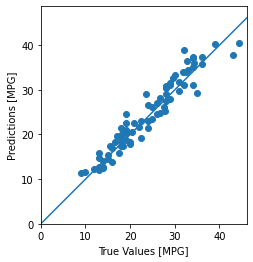

In [26]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

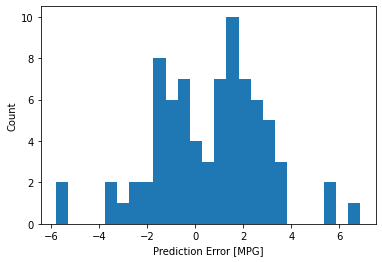

In [27]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")